In [ ]:
!pip install --quiet fastmri

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import fastmri
import h5py
import os

In [3]:
OUTPUT     = "../working"
INPUT      = "../input"
DATA_PATH  = os.path.join(INPUT, "fastmri-knee", "fastmri")
TRAIN_PATH = os.path.join(DATA_PATH, "singlecoil_train")
TEST_PATH  = os.path.join(DATA_PATH, "singlecoil_test")
VAL_PATH   = os.path.join(DATA_PATH, "singlecoil_val")

sample_file = "file1000001.h5"
sample_path = os.path.join(TRAIN_PATH, sample_file)

# Predstavitev podatkov


In [4]:
sample = h5py.File(sample_path)
print(dict(sample.attrs), "\n\n", list(sample.keys()))

{'acquisition': 'CORPDFS_FBK', 'max': 0.000851878253624366, 'norm': 0.0596983310320022, 'patient_id': '0beb8905d9b7fad304389b9d4263c57d5b069257ea0fdc5bf7f2675608a47406'} 

 ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']


Podatki so razdeljeni na train, validation in test datasets. Vsaka binarna `h5` datoteka predstavlja eno MRI slikanje. 
Vsebuje:
- `kspace`: k-space podatke
- `reconstruction_rss`, `reconstruction_esc`: rekonstruirano MRI sliko (ground truth)
- `attrs`: metapodatke o slikanju.

`k_space` so signali frekvenc (?) pridobljeni iz MRI naprave, torej surovi podatki, ki se nato s pomočjo inverzne Fouirerjeve preslikave transformirajo v MRI sliko.

TODO: kaj je reconstruction_esc?

In [5]:
sample["kspace"].shape

(36, 640, 372)

Slikanje vsebuje 36 slojev (posameznih slik) velikosti 640×372 px.

In [6]:
slice = 10
kspace = np.array(sample["kspace"])
sample_slice = kspace[slice]
sample_slice[100:102, 100:102]

array([[-5.6733791e-07+8.8030475e-07j, -1.2970555e-05-8.6704194e-06j],
       [-4.9417745e-06+3.0851206e-06j, -1.3465409e-05-7.6796363e-07j]],
      dtype=complex64)

`kspace` podatki so predstavljeni s kompleksnimi števili, zato jih je treba s pomočjo enačbe *<enačba>* pretvoriti v realna števila.

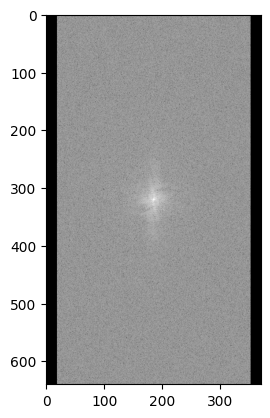

In [7]:
sample_slice_f = np.log(np.abs(sample_slice) + 1e-9)

plt.imshow(sample_slice_f, cmap="gray")
plt.show()

## Primer transformacije *k-space* -> *image space*

In [8]:
from fastmri.data import transforms

In [9]:
kspace_tensor = transforms.to_tensor(kspace)
kspace_complex = fastmri.ifft2c(kspace_tensor)
kspace_complex.shape

torch.Size([36, 640, 372, 2])

`to_tensor` pretvori `numpy.ndarray` kompleksnih podatkov v `torch.Tensor`, kjer sta v zadnji dimenziji ločeni realna in kompleksna komponenta.

`ifft2c` izvede inverzno Fourierjevo transformacijo. 

In [10]:
kspace_complex[0, :3, :3, 0]  # Re

tensor([[ 4.9065e-07,  1.4504e-06,  2.1026e-06],
        [ 1.9407e-06, -4.5079e-06,  3.7221e-06],
        [ 1.6579e-06, -4.1001e-06, -5.8950e-06]])

In [11]:
kspace_complex[0, :3, :3, 1]  # Img

tensor([[ 1.2271e-06, -8.5122e-07,  2.1547e-07],
        [-2.8814e-06,  6.4273e-07,  1.9192e-07],
        [ 1.3289e-06, -1.2626e-06,  5.2304e-07]])

In [12]:
kspace_real = fastmri.complex_abs(kspace_complex)  # vrne realne komponente
kspace_real.shape

torch.Size([36, 640, 372])

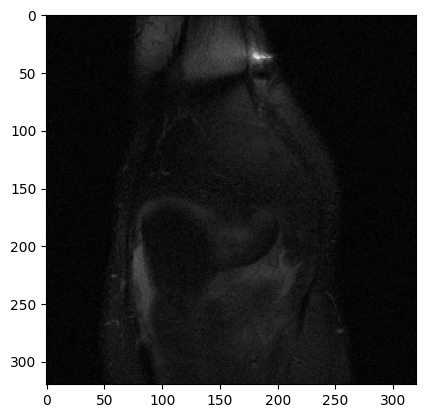

In [13]:
kspace_image = transforms.center_crop(kspace_real[slice], (320, 320))
plt.imshow(kspace_image, cmap="gray")
plt.show()

## Primer rekonstruirane in očiščene slike

In [14]:
ground_truth: h5py.Dataset = sample["reconstruction_rss"]
ground_truth.shape, ground_truth.dtype, ground_truth.dtype.type

((36, 320, 320), dtype('<f4'), numpy.float32)

In [15]:
ground_truth_image = ground_truth[slice]

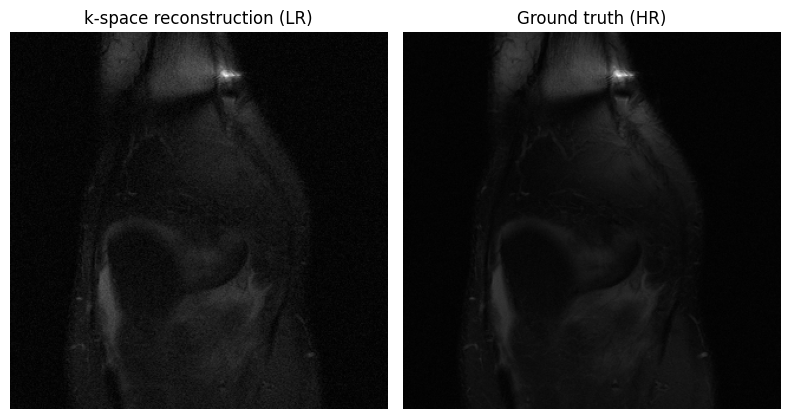

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

axes[0].set_title("k-space reconstruction (LR)")
axes[0].imshow(kspace_image, cmap="gray")
axes[0].axis("off")
axes[1].set_title("Ground truth (HR)")
axes[1].imshow(ground_truth_image, cmap="gray")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [17]:
import imageio
from IPython.display import Image

fname_gif = ''.join([sample_file, '.gif'])

In [18]:
gt_np = np.array(ground_truth)

max_val = gt_np.max()
min_val = gt_np.min()

gt_norm = (gt_np - min_val) / (max_val - min_val) * 255
gt_norm = gt_norm.astype(np.uint8)

In [19]:
imageio.mimsave(fname_gif, gt_norm, duration=0.1, loop=0)

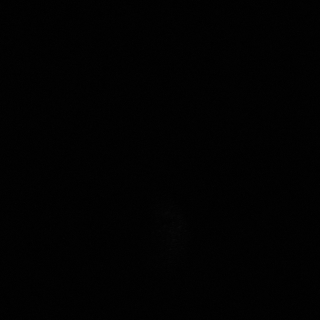

In [20]:
Image(os.path.join(OUTPUT, fname_gif))  # ta gif lah daš čiš gor v uvod

V članku uporabljajo za LR slike downsampled HR slike, torej 

# SRResCycGAN

Izvorne datoteke so dostopne na [kaggle-u](https://www.kaggle.com/datasets/janpanjan/srrescycgan-fastmri/data) in [github-u](https://github.com/JanPanjan/SRResCycGAN_fastMRI/tree/main).

In [254]:
from keras import Model, Loss, Optimizer, layers, metrics
from tensorflow import image, reduce_mean, abs, GradientTape, ones_like, zeros_like, zeros
from keras.losses import MeanSquaredError, BinaryCrossentropy, MeanAbsoluteError
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay

In [ ]:
LR_SHAPE = (80, 80, 3)
HR_SHAPE = (320, 320, 3)

## Generatorja

In [ ]:
def Generator_HR(input_shape=LR_SHAPE):
    """ Generator za HR (high resolution) slike.

    Deluje na principu "upscale -> refine". Sprejme sliko nizke ločljivosti in
    vrne izboljšano sliko visok ločljivosti. Arhitektura temelji na članku o SRResCGAN.
    Ima 3 glavne dele:

    1. Encoder - upsampling vhodne slike in ekstrakcija značilnosti
    2. ResidualNet - predela zemljevid značilnosti (feature map) od encoderja
    3. Decoder - na podalagi izhoda ResNet-a ustvari zemljevid napak (proximal map)

    `Subtract` sloj zmanjša prisotnost šuma in artefaktov upsampled slike s pomočjo
    zemljevida napak. Zadnji `Conv2D` sloj poskrbi, da je izhod slika s tremi kanali.

    Args:
        input_shape: dimenzija LR slike (width, height, channels)
    Returns:
        HR slika dimenzije (320, 320, 3)
    """
    lr_input = layers.Input(shape=input_shape)
    encoder_out = layers.Conv2DTranspose(
        filters=64,     # število kanalov izhoda; rgb slika ima 3, tu jih vrne 64)
        kernel_size=5,  # dimenzije jedra, ki bo procesiral sliko (5x5)
        strides=4,      # za koliko pikslov se premakne jedro (4 => 4x upsampling => vodi v 320x320), ko je padding="same"
        padding="same"  # poskrbi, da se doda ravno prav ničel na robove, da je končna dimenzija odvisna od strides
    )(lr_input)

    global_skip = encoder_out

    # služi kot vhod in izhod ResNet-a.
    x = layers.Conv2D(filters=64, kernel_size=5, padding="same")(encoder_out)

    for _ in range(5):
        block_skip = x
        x = layers.PReLU(shared_axes=[1, 2])(block_skip)
        x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
        x = layers.GroupNormalization(groups=-1, axis=-1)(x)  # -1 za InstanceNormalization

        x = layers.PReLU(shared_axes=[1, 2])(x)
        x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", use_bias=False)(x)
        x = layers.GroupNormalization(groups=-1, axis=-1)(x)
        x = layers.Add()([block_skip, x])

    decoder_out = layers.Conv2D(filters=64, kernel_size=5, strides=1, padding="same")(x)
    decoder_out = layers.Conv2D(filters=64, kernel_size=5, strides=1, padding="same")(decoder_out)

    subtracted = layers.Subtract()([global_skip, decoder_out])
    model_out = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding="same", use_bias=False)(subtracted)
    model_out = layers.ReLU(max_value=255)(model_out)  # vrednosti spravi na interval [0,255]

    return Model(inputs=lr_input, outputs=model_out, name="G_HR")

In [ ]:
def Generator_LR(input_shape=HR_SHAPE):
    """ Generator za LR (low resolution) slike.

    Sprejme sliko visoke ločljivosti in vrne degradirano sliko nizke ločljivosti. Arhitektura temelji
    na G3 generatorju iz CinCGAN strukture, ki opravi downsampling s pomočjo konvolucije.
    Ima 3 glavne dele:

    1. Glava - downsampling in ekstrakcija značilnosti
    2. ResidualNet - predela izdelan zemljevid značilnosti (feature map)
    3. Rep - transformacija nazaj v sliko s tremi kanali

    Args:
        input_shape: dimenzija HR slike (width, height, channels)
    Returns:
        HR slika dimenzije (320, 320, 3)
    """
    hr_input = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters=64, kernel_size=7, padding="same")(hr_input)
    x = layers.GroupNormalization(groups=-1, axis=-1)(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    for _ in range(2):  # downsample
        x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
        x = layers.GroupNormalization(groups=-1, axis=-1)(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

    for _ in range(6): # ResNet
        block_skip = x
        x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
        x = layers.GroupNormalization(groups=-1, axis=-1)(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

        x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
        x = layers.GroupNormalization(groups=-1, axis=-1)(x)
        x = layers.Add()([block_skip, x])
        x = layers.LeakyReLU(negative_slope=0.2)(x)

    for _ in range(2):
        x = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x)
        x = layers.GroupNormalization(groups=-1, axis=-1)(x)
        x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Conv2D(filters=3, kernel_size=7, padding="same")(x)
    model_out = layers.ReLU(max_value=255)(x)  # vrednosti spravi na interval [0,255]

    return Model(inputs=hr_input, outputs=model_out, name="G_LR")

## Diskriminatorja

In [ ]:
def Discriminator_HR(input_shape=HR_SHAPE):
    """ Diskriminator za HR (high resolution) slike.

    Sprejme HR sliko (pravo ali lažno) in vrne verjetnost,
    da je slika prava. Deluje kot binarni klasifikator.
    Arhitektura temelji na članku o SRResCGAN. Ima 3 glavne dele:

    1. Vhodni konvolucijski blok
    2. Zaporedje konvolucjiskih blokov, ki
       - postopoma zmanjšujejo dimenzijo slike,
       - normalizirajo vrednosti za stabilizacijo pri treniranju
       - večajo število filtrov za procesiranje lastnosti slike
    3. Fully connected sloji, ki poskrbijo, da se vrne ena float vrednost

    Args:
        input_shape: dimenzija HR slike (width, height, channels)
    Returns:
        float logit vrednost
    """
    hr_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="valid")(hr_input)
    x = layers.LeakyReLU()(x)

    KERNEL_SIZE = (4, 3)
    STRIDES = (2, 1)
    FILTERS = (
        64,
        128, 128,
        256, 256,
        512, 512, 512, 512
    )

    for i in range(9):
        kernel_size = KERNEL_SIZE[0] if i % 2 == 0 else KERNEL_SIZE[1]
        strides = STRIDES[0] if i % 2 == 0 else STRIDES[1]

        x = layers.Conv2D(filters=FILTERS[i], kernel_size=kernel_size, strides=strides, padding="valid")(x)
        # TODO: Spectral Normalization?
        x = layers.GroupNormalization(groups=-1, axis=-1)(x)
        x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(units=100)(x)
    x = layers.LeakyReLU()(x)
    model_out = layers.Dense(units=1)(x)

    return Model(inputs=hr_input, outputs=model_out, name="D_HR")

In [ ]:
def Discriminator_LR(input_shape=LR_SHAPE):
    """ Diskriminator za LR (low resolution) slike.

    Arhitektura temelji PatchGAN diskriminatorju, kot opisujejo v članku o SRResCycGAN, ki vrne matriko
    ocen verjetnosti (logitov) namesto ene same vrednosti. Tak pristop spodbuja generator, da se osredotoči
    na ustvarjanje realističnih lokalnih podrobnosti. Namesto BatchNormalization je uporabljena
    InstanceNormalization, saj se obnese boljše med treniranjem.

    Args:
        input_shape: dimenzija LR slike (width, height, channels)
    Returns:
        matrika logitov oblike (20, 20, 1)
    """
    lr_input = layers.Input(shape=input_shape)
    KERNEL_SIZE = 5

    x = layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, strides=2, padding="same")(lr_input)
    x = layers.GroupNormalization(groups=-1, axis=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, strides=2, padding="same")(x)
    x = layers.GroupNormalization(groups=-1, axis=-1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE, padding="same")(x)
    x = layers.GroupNormalization(groups=-1, axis=-1)(x)
    x = layers.LeakyReLU()(x)

    model_out = layers.Conv2D(filters=1, kernel_size=KERNEL_SIZE, padding="same")(x)

    return Model(inputs=lr_input, outputs=model_out, name="D_LR")

## Loss funckije

In [ ]:
def total_variation(real_image, fake_image):
    """Total variation loss

    Primerja vodoravne in navpične gradiente resnične in generirane slike. Imenovan tudi
    "gradient difference loss".

    Vrne vsoto razlik gradientov obeh slik.
    """
    real_dy, real_dx = image.image_gradients(real_image)
    fake_dy, fake_dx = image.image_gradients(fake_image)

    loss_dx = reduce_mean(abs(real_dx - fake_dx))
    loss_dy = reduce_mean(abs(real_dy - fake_dy))

    return loss_dx + loss_dy

In [ ]:
class PerceptualLoss(Loss):
    """Perceptual loss

    Sliki primerja v prostoru značilnosti (feature space) namesto prostoru slik (image space).
    Feature maps sta dobljena iz nekega vmesnega konvolucijskega sloja VGG19 klasifikatorja.

    Vrne MSE (L2 loss) nad izhodom VGG19 za resnično in generirano sliko.
    """

    def __init__(self, hr_shape=HR_SHAPE) -> None:
        super(PerceptualLoss, self).__init__(name="perceptual_loss")
        self.vgg_model = self.__build_vgg_model(hr_shape)
        self.L2 = MeanSquaredError()

    def __build_vgg_model(self, hr_shape):
        vgg = VGG19(input_shape=hr_shape, include_top=False, weights="imagenet")
        vgg.trainable = False
        # Izhod enega od vmesnih slojev
        output_layer = vgg.get_layer("block3_conv3").output
        return Model(inputs=vgg.input, outputs=output_layer, name="vgg_perceptual")

    def call(self, y_true, y_pred):
        true_preproc = preprocess_input(y_true)
        pred_preproc = preprocess_input(y_pred)
        true_feat = self.vgg_model(true_preproc, training=False)
        pred_feat = self.vgg_model(pred_preproc, training=False)
        return self.L2(true_feat, pred_feat)

In [ ]:
losses_dict = {
    "perceptual": PerceptualLoss(),
    "adversarial": BinaryCrossentropy(from_logits=True),
    "total_variation": total_variation,
    "content": MeanAbsoluteError(),
    "cyclic": MeanAbsoluteError(),
}

## Primer generirane slike

In [ ]:
import tensorflow as tf
t = tf.random.uniform(shape=(1, *LR_SHAPE), minval=0.0, maxval=255.0, dtype=tf.float32)
ghr = Generator_HR()
generated_img = ghr(t)
plt.imshow(generated_img[0].numpy().astype(np.uint8))

In [ ]:
dhr = Discriminator_HR()
dhr(generated_img)

## Celotni model

In [ ]:
class SRResCycGAN(Model):
    """
    Super Resolution Residual Cyclic GAN
    """
    def __init__(self, lambda_cyc=10.0, lambda_content=5.0) -> None:
        super(SRResCycGAN, self).__init__()

        self.G_HR = Generator_HR(input_shape=LR_SHAPE)
        self.G_LR = Generator_LR(input_shape=HR_SHAPE)
        self.D_HR = Discriminator_HR(input_shape=HR_SHAPE)
        self.D_LR = Discriminator_LR(input_shape=LR_SHAPE)
        self.lambda_cyc = lambda_cyc
        self.lambda_content = lambda_content

        # trackers
        self.d_hr_loss_tracker = metrics.Mean(name="d_hr_loss")
        self.d_lr_loss_tracker = metrics.Mean(name="d_lr_loss")
        self.g_adv_loss_tracker = metrics.Mean(name="g_adv_loss")
        self.g_cyc_loss_tracker = metrics.Mean(name="g_cyc_loss")
        self.g_content_loss_tracker = metrics.Mean(name="g_content_loss")
        self.g_perceptual_loss_tracker = metrics.Mean(name="g_perceptual_loss")
        self.g_tv_loss_tracker = metrics.Mean(name="g_tv_loss")
        self.total_gen_loss_tracker = metrics.Mean(name="total_g_loss")
        self.total_disc_loss_tracker = metrics.Mean(name="total_d_loss")

        self.mse_tracker = metrics.Mean(name="mse")
        self.psnr_tracker = metrics.Mean(name="psnr")

    def compile(self,
        g_hr_optimizer: Optimizer,
        d_hr_optimizer: Optimizer,
        g_lr_optimizer: Optimizer,
        d_lr_optimizer: Optimizer,
        losses: dict[str, Loss]
    ):
        super(SRResCycGAN, self).compile()

        self.g_hr_optimizer = g_hr_optimizer
        self.d_hr_optimizer = d_hr_optimizer
        self.g_lr_optimizer = g_lr_optimizer
        self.d_lr_optimizer = d_lr_optimizer

        self.adv_loss = losses["adversarial"]
        self.cyc_loss = losses["cyclic"]
        self.content_loss = losses["content"]
        self.perceptual_loss = losses["perceptual"]
        self.tv_loss = losses["total_variation"]


    def train_step(self, data):
        real_lr, real_hr = data

        with GradientTape(persistent=True) as disc_tape:
            # generira slike
            fake_hr = self.G_HR(real_lr, training=True)
            fake_lr = self.G_LR(real_hr, training=True)

            # diskriminira
            real_hr_pred = self.D_HR(real_hr, training=True)
            fake_hr_pred = self.D_HR(fake_hr, training=True)

            real_lr_pred = self.D_LR(real_lr, training=True)
            fake_lr_pred = self.D_LR(fake_lr, training=True)

            # discriminator losses
            dhr_real_loss = self.adv_loss(ones_like(real_hr_pred), real_hr_pred)
            dhr_fake_loss = self.adv_loss(zeros_like(fake_hr_pred), fake_hr_pred)
            dhr_total_loss = (dhr_real_loss + dhr_fake_loss) * 0.5

            dlr_real_loss = self.adv_loss(ones_like(real_lr_pred), real_lr_pred)
            dlr_fake_loss = self.adv_loss(zeros_like(fake_lr_pred), fake_lr_pred)
            dlr_total_loss = (dlr_real_loss + dlr_fake_loss) * 0.5

            total_disc_loss = dhr_total_loss + dlr_total_loss


        with GradientTape(persistent=True) as gen_tape:
            # generira slike
            fake_hr = self.G_HR(real_lr, training=True)
            fake_lr = self.G_LR(real_hr, training=True)
            cycled_hr = self.G_HR(fake_lr, training=True)
            cycled_lr = self.G_LR(fake_hr, training=True)

            # diskriminira za adversarial loss
            fake_hr_pred_gen = self.D_HR(fake_hr, training=True)
            fake_lr_pred_gen = self.D_LR(fake_lr, training=True)

            # generator losses
            perceptual_loss = self.perceptual_loss(real_hr, fake_hr)

            ghr_adv = self.adv_loss(ones_like(fake_hr_pred_gen), fake_hr_pred_gen)
            glr_adv = self.adv_loss(ones_like(fake_lr_pred_gen), fake_lr_pred_gen)
            adv_loss = ghr_adv + glr_adv

            tv_loss = self.tv_loss(real_hr, fake_hr)

            content_loss = self.content_loss(real_hr, fake_hr)

            # cyclic loss
            cyc_forward = self.cyc_loss(cycled_lr, real_lr)
            cyc_backward = self.cyc_loss(cycled_hr, real_hr)
            cyc_loss = cyc_forward + cyc_backward

            total_gen_loss = perceptual_loss + adv_loss + tv_loss + \
                            (content_loss * self.lambda_content) + \
                            (cyc_loss * self.lambda_cyc)


        # gradienti diskriminatorja
        dhr_grads = disc_tape.gradient(dhr_total_loss, self.D_HR.trainable_variables)
        dlr_grads = disc_tape.gradient(dlr_total_loss, self.D_LR.trainable_variables)

        self.d_hr_optimizer.apply_gradients(zip(dhr_grads, self.D_HR.trainable_variables))
        self.d_lr_optimizer.apply_gradients(zip(dlr_grads, self.D_LR.trainable_variables))

        # gradienti generatorja
        ghr_grads = gen_tape.gradient(total_gen_loss, self.G_HR.trainable_variables)
        glr_grads = gen_tape.gradient(total_gen_loss, self.G_LR.trainable_variables)

        self.g_hr_optimizer.apply_gradients(zip(ghr_grads, self.G_HR.trainable_variables))
        self.g_lr_optimizer.apply_gradients(zip(glr_grads, self.G_LR.trainable_variables))

        # Posodobi stanje trackerjev z novimi vrednostmi
        self.d_hr_loss_tracker.update_state(dhr_total_loss)
        self.d_lr_loss_tracker.update_state(dlr_total_loss)
        self.total_disc_loss_tracker.update_state(total_disc_loss)

        self.g_adv_loss_tracker.update_state(adv_loss)
        self.g_cyc_loss_tracker.update_state(cyc_loss)
        self.g_content_loss_tracker.update_state(content_loss)
        self.g_perceptual_loss_tracker.update_state(perceptual_loss)
        self.g_tv_loss_tracker.update_state(tv_loss)
        self.total_gen_loss_tracker.update_state(total_gen_loss)

        mse_metric = reduce_mean(square(real_hr - fake_hr))
        psnr_metric = image.psnr(real_hr, fake_hr, max_val=255.0)
        self.mse_tracker.update_state(mse_metric)
        self.psnr_tracker.update_state(psnr_metric)

        # za progress bar
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        real_lr, real_hr = data

        # training=False ker nočemo da posodablja uteži
        fake_hr = self.G_HR(real_lr, training=False)
        fake_lr = self.G_LR(real_hr, training=False)
        cycled_hr = self.G_HR(fake_lr, training=False)
        cycled_lr = self.G_LR(fake_hr, training=False)

        real_hr_pred = self.D_HR(real_hr, training=False)
        fake_hr_pred = self.D_HR(fake_hr, training=False)
        real_lr_pred = self.D_LR(real_lr, training=False)
        fake_lr_pred = self.D_LR(fake_lr, training=False)

        # enako kot train_step
        dhr_real_loss = self.adv_loss(ones_like(real_hr_pred), real_hr_pred)
        dhr_fake_loss = self.adv_loss(zeros_like(fake_hr_pred), fake_hr_pred)
        dhr_total_loss = (dhr_real_loss + dhr_fake_loss) * 0.5
        dlr_real_loss = self.adv_loss(ones_like(real_lr_pred), real_lr_pred)
        dlr_fake_loss = self.adv_loss(zeros_like(fake_lr_pred), fake_lr_pred)
        dlr_total_loss = (dlr_real_loss + dlr_fake_loss) * 0.5
        total_disc_loss = dhr_total_loss + dlr_total_loss

        ghr_adv = self.adv_loss(ones_like(fake_hr_pred), fake_hr_pred)
        glr_adv = self.adv_loss(ones_like(fake_lr_pred), fake_lr_pred)
        adv_loss = ghr_adv + glr_adv
        tv_loss = self.tv_loss(real_hr, fake_hr)
        content_loss = self.content_loss(real_hr, fake_hr)
        cyc_forward = self.cyc_loss(cycled_lr, real_lr)
        cyc_backward = self.cyc_loss(cycled_hr, real_hr)
        cyc_loss = cyc_forward + cyc_backward
        total_gen_loss = perceptual_loss + adv_loss + tv_loss + \
                        (content_loss * self.lambda_content) + \
                        (cyc_loss * self.lambda_cyc)

        # Posodobi stanje trackerjev z novimi vrednostmi
        self.d_hr_loss_tracker.update_state(dhr_total_loss)
        self.d_lr_loss_tracker.update_state(dlr_total_loss)
        self.total_disc_loss_tracker.update_state(total_disc_loss)

        self.g_adv_loss_tracker.update_state(adv_loss)
        self.g_cyc_loss_tracker.update_state(cyc_loss)
        self.g_content_loss_tracker.update_state(content_loss)
        self.g_perceptual_loss_tracker.update_state(perceptual_loss)
        self.g_tv_loss_tracker.update_state(tv_loss)
        self.total_gen_loss_tracker.update_state(total_gen_loss)

        mse_metric = reduce_mean(square(real_hr - fake_hr))
        psnr_metric = image.psnr(real_hr, fake_hr, max_val=255.0)
        self.mse_tracker.update_state(mse_metric)
        self.psnr_tracker.update_state(psnr_metric)

        # za progress bar
        return {m.name: m.result() for m in self.metrics}

    def call(self, inputs, training=False):
        # samo vrne generirano HR sliko
        return self.G_HR(inputs, training=training)

    @property
    def metrics(self):
        return [
            self.d_hr_loss_tracker,
            self.d_lr_loss_tracker,
            self.total_disc_loss_tracker,
            self.g_adv_loss_tracker,
            self.g_cyc_loss_tracker,
            self.g_content_loss_tracker,
            self.g_perceptual_loss_tracker,
            self.g_tv_loss_tracker,
            self.total_gen_loss_tracker,
            self.mse_tracker,
            self.psnr_tracker,
        ]

## Data loading

In [ ]:
from typing import Generator
import tensorflow as tf
import keras
import numpy as np
import h5py
import os

In [ ]:
BATCH_SIZE = 4
BUFFER_SIZE = 1000
BLOCK_LENGTH = 1

In [ ]:
def h5_generator(filepath) -> Generator[tuple[np.ndarray, np.ndarray], None, None]:
    """
    Generator, ki vrača (lr, hr) pare slik iz H5 datotek z uporabo NumPy.
    """
    with h5py.File(filepath.decode('utf-8'), "r") as hf:
        hr_images_raw = np.array(hf["reconstruction_rss"])
        
        channels = hr_images_raw.shape[0]

        for i in range(channels):
            hr_image = hr_images_raw[i].astype(np.float32)

            # zagotovi da je slika vsaj 3D (doda chanels dimenzijo, če manjka)
            if hr_image.ndim == 2:
                hr_image = np.expand_dims(hr_image, axis=-1) # (320, 320) -> (320, 320, 1)

            # če ima slika 2 kanala, vzamemo samo prvega (morda lahko ostranim)
            if hr_image.shape[-1] == 2:
                hr_image = hr_image[..., 0:1] # (320, 320, 2) -> (320, 320, 1)

            # zagotovi da ima 3 kanale (nisem prepričan ali je to pravi pristop)
            # np.tile ponovi array po določeni osi.
            if hr_image.shape[-1] == 1:
                hr_image = np.tile(hr_image, (1, 1, 3)) # (320, 320, 1) -> (320, 320, 3)
            
            assert hr_image.shape == HR_SHAPE

            # ustvari LR sliko z downsampling-om
            hr_image_tensor = tf.constant(hr_image)
            lr_image = tf.image.resize(hr_image_tensor, LR_SHAPE[:2], method=tf.image.ResizeMethod.BICUBIC)

            yield lr_image.numpy(), hr_image

In [ ]:
def create_paired_dataset(data_dir) -> tf.data.Dataset:
    """
    Ustvari `tf.data.Dataset` s parnimi podatki LR in HR slik. LR slike predstavljajo transformirani k-space
    podatki, HR pa rekonstruirane in prečiščene slike dostopne znotraj datotek pod `reconstruction_rss`.
    """
    filepaths_pattern = os.path.join(data_dir, "*.h5")

    # `from_generator` spodaj pričakuje signiature izhodnih podatkov
    # vsak `yield` bo vrnil dve sliki, LR in HR, primernih oblik
    out_sig = (
        tf.TensorSpec(shape=LR_SHAPE, dtype=tf.float32),
        tf.TensorSpec(shape=HR_SHAPE, dtype=tf.float32)
    )

    # dataset z imeni vseh datotek
    filepaths_dataset = tf.data.Dataset.list_files(filepaths_pattern, shuffle=False)

    # z generatorjem odpre vsako datoteko posebej in postopoma z `yield` vrača pare slik
    paired_dataset = filepaths_dataset.interleave(
        lambda filepath: tf.data.Dataset.from_generator(
            generator=h5_generator,
            output_signature=out_sig,
            args=(filepath,)  # vejica, ker mora biti sequence
        ),
        cycle_length=tf.data.AUTOTUNE,       # število vhodnih elementov, ki se procesirajo istočasno
        block_length=BLOCK_LENGTH,           # da zajame vse slike v datoteki, ker ni fiksnega števila slojev
        num_parallel_calls=tf.data.AUTOTUNE  # za hitrejše procesiranje
    )

    paired_dataset = paired_dataset.shuffle(buffer_size=BUFFER_SIZE)
    paired_dataset = paired_dataset.batch(BATCH_SIZE)
    paired_dataset = paired_dataset.prefetch(tf.data.AUTOTUNE)

    return paired_dataset

## Training

In [ ]:
EPOCHS = 1

In [ ]:
train = create_paired_dataset(TRAIN_PATH)
val = create_paired_dataset(VAL_PATH)

In [ ]:
model = SRResCycGAN(lambda_cyc=10.0, lambda_content=5.0)

In [ ]:
def adam_opt(lr=1e-4, b1=0.9, b2=0.999, decay_steps=1e4, decay_rate=0.5):
    lr_schedule = ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True  # da se lr spremeni na vsakih 10k korakov
    )
    return Adam(learning_rate=lr_schedule, beta_1=b1, beta_2=b2, weight_decay=False)

In [ ]:
g_hr_optimizer = adam_opt()
d_hr_optimizer = adam_opt()
g_lr_optimizer = adam_opt()
d_lr_optimizer = adam_opt()

model.compile(
    g_hr_optimizer=g_hr_optimizer,
    d_hr_optimizer=d_hr_optimizer,
    g_lr_optimizer=g_lr_optimizer,
    d_lr_optimizer=d_lr_optimizer,
    losses=losses_dict
)

In [ ]:
def calculate_slices(data_dir) -> int:
    print("Calculating slices for ", data_dir, "...")
    total_slices = 0
    for f in os.listdir(data_dir):
        with h5py.File(os.path.join(data_dir, f), "r") as hf:
            total_slices += hf["reconstruction_rss"].shape[0]
    print("Total slices:", total_slices)
    return total_slices

In [ ]:
total_train_slices = calculate_slices(TRAIN_PATH)
total_val_slices = calculate_slices(VAL_PATH)

In [ ]:
steps_per_epoch = total_train_slices // BATCH_SIZE
steps_per_epoch

In [ ]:
validation_steps = total_val_slices // BATCH_SIZE
validation_steps

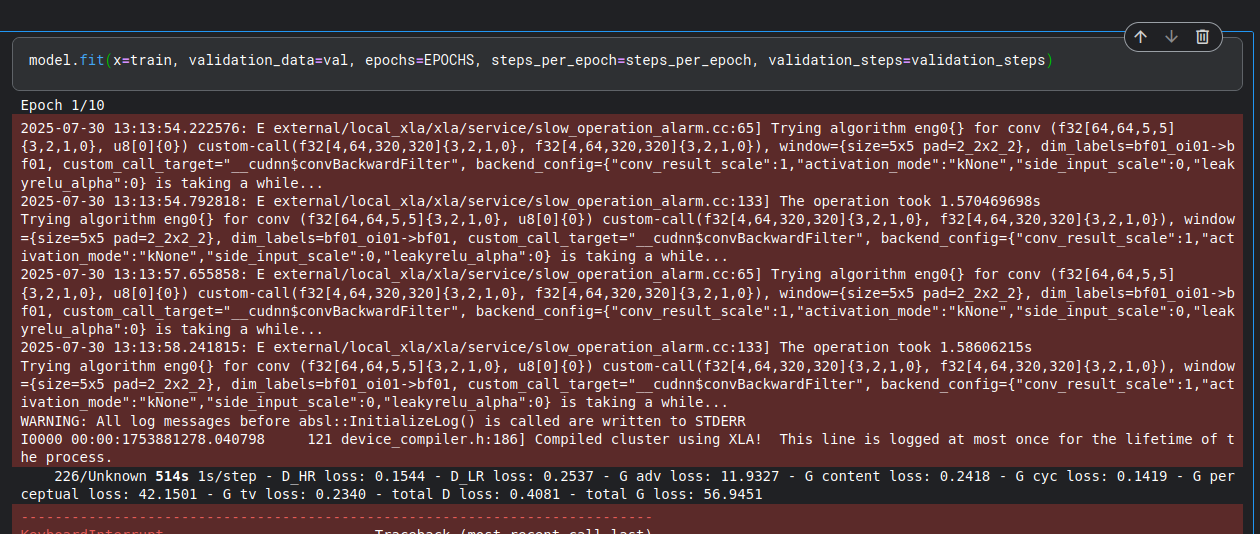

S trenutnim naborom podatkov bi moral čakati kakšen teden, da se vse izvede. Namesto tega bom drastično zmanjšal število slik, ki bodo uporabljene. 

In [ ]:
MAX_FILES_TO_USE = 300

In [ ]:
import random
import glob

all_train_files = glob.glob(os.path.join(TRAIN_PATH, "*.h5"))
random.shuffle(all_train_files)

train_files = all_train_files[:MAX_FILES_TO_USE]

all_val_files = glob.glob(os.path.join(VAL_PATH, "*.h5"))
random.shuffle(all_val_files)

val_files = all_val_files[:int(MAX_FILES_TO_USE * 0.2)] # Npr. 20%

In [ ]:
def create_paired_dataset_from_list(filepaths: list) -> tf.data.Dataset:
    """
    Podobno kot `create_paired_dataset`, le da vzame kot parameter seznam datotek.
    """
    # `from_generator` spodaj pričakuje signiature izhodnih podatkov
    # vsak `yield` bo vrnil dve sliki, LR in HR, primernih oblik
    out_sig = (
        tf.TensorSpec(shape=LR_SHAPE, dtype=tf.float32),
        tf.TensorSpec(shape=HR_SHAPE, dtype=tf.float32)
    )

    # dataset z imeni vseh datotek
    filepaths_dataset = tf.data.Dataset.from_tensor_slices(filepaths)

    # z generatorjem odpre vsako datoteko posebej in postopoma z `yield` vrača pare slik
    paired_dataset = filepaths_dataset.interleave(
        lambda filepath: tf.data.Dataset.from_generator(
            generator=h5_generator,
            output_signature=out_sig,
            args=(filepath,)  # vejica, ker mora biti sequence
        ),
        cycle_length=tf.data.AUTOTUNE,       # število vhodnih elementov, ki se procesirajo istočasno
        block_length=BLOCK_LENGTH,           # da zajame vse slike v datoteki, ker ni fiksnega števila slojev
        num_parallel_calls=tf.data.AUTOTUNE  # za hitrejše procesiranje
    )

    paired_dataset = paired_dataset.shuffle(buffer_size=BUFFER_SIZE)
    paired_dataset = paired_dataset.batch(BATCH_SIZE)
    paired_dataset = paired_dataset.prefetch(tf.data.AUTOTUNE)

    return paired_dataset

In [ ]:
def calculate_slices_v2(filepaths) -> int:
    total_slices = 0
    print("Calculating slices for ", filepaths[0][30:46], "...") # the string slicing
    for f in filepaths:
        with h5py.File(f, "r") as hf:
            total_slices += hf["reconstruction_rss"].shape[0]
    print("Total slices:", total_slices)
    return total_slices

In [ ]:
total_train_slices_sub = calculate_slices_v2(train_files)
total_val_slices_sub = calculate_slices_v2(val_files)

In [ ]:
steps_per_epoch_sub = total_train_slices_sub // BATCH_SIZE
steps_per_epoch_sub

In [ ]:
val_steps_sub = total_val_slices_sub // BATCH_SIZE
val_steps_sub

In [ ]:
train_sub = create_paired_dataset_from_list(train_files)
val_sub = create_paired_dataset_from_list(val_files)

In [ ]:
model.fit(x=train_sub, validation_data=val_sub, epochs=EPOCHS, steps_per_epoch=steps_per_epoch_sub, validation_steps=val_steps_sub)